## Section 2 - Response Time Forecasting Under User Growth 
In this section we will address the fact that tavily plans to increase the number of its users, how the system will function if we double the number of its participants.
We will explore the data in a basic way first, classic EDA steps, we will learn about the relationship between the resp_avg column and the volume column.
And we will try to predict the resp_avg as a function of volume

In [29]:
#import libs 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

In [3]:
#read the data
df = pd.read_csv('Tavily Data Analysis Home Test - Time Series.csv')
df.head()

,DATE_TIME,VOLUME,RESP_AVG
0,2025-03-22 8:00:00,442,7.085964
1,2025-03-22 9:00:00,418,8.405124
2,2025-03-22 11:00:00,507,7.779719
3,2025-03-22 12:00:00,559,6.877425
4,2025-03-22 13:00:00,602,8.178685


In [6]:
df = df.set_index('DATE_TIME')
df.index = pd.to_datetime(df.index)
print(df.info())
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1706 entries, 2025-03-22 08:00:00 to 2025-06-15 07:00:00
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   VOLUME    1706 non-null   int64  
 1   RESP_AVG  1706 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 40.0 KB
None
             VOLUME     RESP_AVG
count   1706.000000  1706.000000
mean    2640.644197     7.848615
std     2410.114417     2.171984
min      362.000000     4.594024
25%     1136.000000     6.904281
50%     2052.500000     7.694853
75%     3297.000000     8.506829
max    23259.000000    64.354239


### EDA - basic scatter
analyiz the relasionship between VOLUME and RESP_AVG

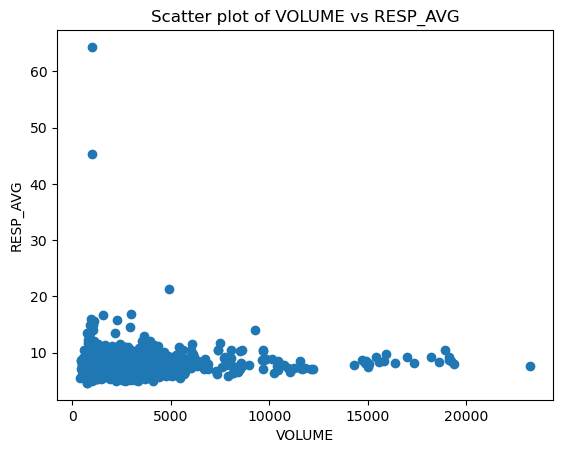

In [8]:
plt.scatter(df['VOLUME'], df['RESP_AVG'])
plt.xlabel('VOLUME')
plt.ylabel('RESP_AVG')
plt.title('Scatter plot of VOLUME vs RESP_AVG')
plt.show()

### Points that emerge from the graph analysis:
1. Large focus in a small area in the values ​​of volume: Most of the points move and are concentrated between values ​​of 0-5000 of volume, with resp_avg moving between 5-15 without a very clear trend

2. There is no clear trend line in the graph. There is no sharp slope of the scatter, which converges with reference to the next stage of the correlation -> no significant linear relationship.

In [10]:
#calculate the correlation
pearson_corr , pearson_p_value = pearsonr(df['VOLUME'], df['RESP_AVG'])
spearman_corr, spearman_p_value = spearmanr(df['VOLUME'], df['RESP_AVG'])

print(f"Pearson correlation: {pearson_corr:.3f}, p-value: {pearson_p_value:.3f}")
print(f"Spearman correlation: {spearman_corr:.3f}, p-value: {spearman_p_value:.3f}")

Pearson correlation: 0.060, p-value: 0.013
Spearman correlation: 0.161, p-value: 0.000


# Explanations of the correlation indices and their impact according to the graph:
* **Pearson** - measures the linear relationship between volume and resp_avg.
According to the data released, it can be seen that the correlation is almost close to 0, which shows that there is almost no linear correlation.
* **Spearman** - measures the monotonic relationship between two variables. 
According to the results of 0.16, which is relatively small-medium, we can conclude that as soon as the volume index increases, resp_avg will also increase, but again, this is a weak relationship, so you should not take it as an assumption.

### Meanings:
1. The system manages to maintain a similar average response time between different loads most of the time, only in exceptional cases do we see peaks that increase.
2. We should integrate additional features such as - rolling mean, trends, seasonality .. or models that are not linear in order to capture the impact of traffic.

In [11]:
#feature engineering
df['log_VOLUME'] = np.log1p(df['VOLUME'])
df['resp_per_logreq'] = df['RESP_AVG'] / df['log_VOLUME']

stats = df[['log_VOLUME','resp_per_logreq']].describe()
print(stats)

        log_VOLUME  resp_per_logreq
count  1706.000000      1706.000000
mean      7.617905         1.037282
std       0.692027         0.313372
min       5.894403         0.596557
25%       7.036148         0.905787
50%       7.627301         1.009039
75%       8.101072         1.120064
max      10.054490         9.293551


/Users/jonatanbuga/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jonatanbuga/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


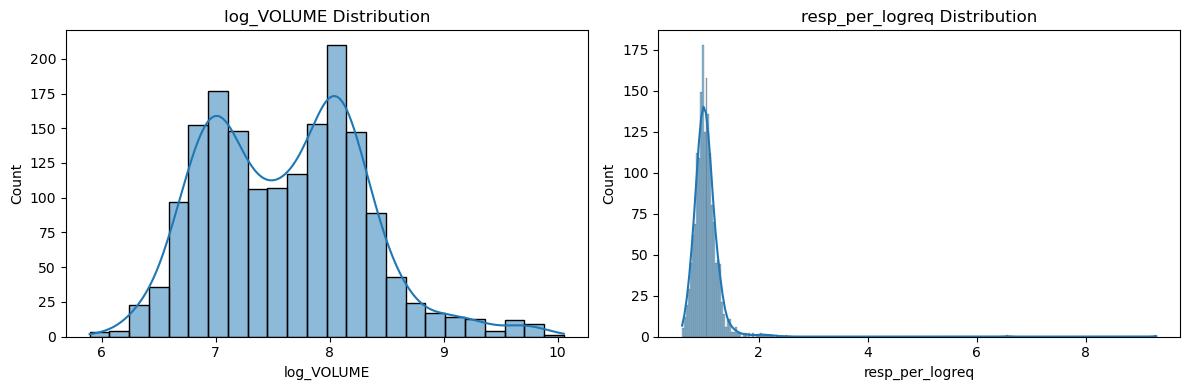

In [12]:
#visualize the new features
fig, axes = plt.subplots(1,2,figsize=(12,4))
sns.histplot(df['log_VOLUME'],ax=axes[0], kde=True).set_title('log_VOLUME Distribution')
sns.histplot(df['resp_per_logreq'], ax=axes[1], kde=True).set_title('resp_per_logreq Distribution')
plt.tight_layout()
plt.show()

### Effects of normalizing our data by log and how to proceed with model selection:
1. **Near-normal distribution of volume**-
After performing log on the values ​​of the volume column, I wanted to soften the values ​​between 0-20000 a little to smaller values.

* **Meanings**
    * Improved statistical stability- Models that assume analysis on data that is close to normal (like Isolation Forest) will perform better and are less likely to be biased by extreme values.
    * Reduced impact on outliers- High values ​​in volume will not continue the model's slope in all directions.

2. **Right-tailed distribution for resp_per_logreq** 
Most of the values ​​are clustered around the 0 point of the x-axis and there is a right tail that continues further in its values, these are actually the tails that represent the abnormal points of the average response time in relation to the number of requests

* **Meanings**
    * The anomaly points are clearer - instead of resp_avg being captured only through extreme values, the ratio divides the values ​​in such a way that the highest ratio is the place to look.
    * Better threshold selection - Instead of defining threshold VOLUME or RESP_AVG separately, we can limit the anomaly to some k value so that we set the threshold on them.

### Feather Engineering

In [19]:
df['hour']    = df.index.hour
df['weekday'] = df.index.weekday
df['rm_resp'] = df['RESP_AVG'].rolling(3).mean()
df['rs_resp'] = df['RESP_AVG'].rolling(3).std()

In [20]:
#drop rows with NaN values
df = df.dropna(subset=['rm_resp','rs_resp'])

In [21]:
#split the data into train and test sets
feature_cols = ['log_VOLUME','hour','weekday','rm_resp','rs_resp']
X = df[feature_cols]
y = df['RESP_AVG']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
#scaleing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

### Meanings of choosing these additional features and approach to data normalization:
I chose to add some basic features to enrich my data, for the purpose of executing and improving the basic model that we will refer to later.

Features like mean and std on the resp_avg column in addition to days of the week and hours, can add more meat to my model later.

### Normalizing the features
An important and significant step in feeding the data into the training of the model is to understand that linear models usually like to behave and work with data at the same scale, because a model like regression will give excessive weight to the feature at a higher scale.

In [32]:
#choose a model
model = LinearRegression()

#train the model
model.fit(X_train_scaled, y_train)

LinearRegression()

In [33]:
#predict the test set
y_pred = model.predict(X_test_scaled)

#evaluate the model
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred,squared=False)

print(f"R^2: {r2:.3f}, RMSE: {rmse:.3f}")

R^2: 0.387, RMSE: 2.636


**r2_score** shows how well the model fits the 45° line (1.0 = perfect fit).

**RMSE** (Root Mean Square Error) in seconds, shows the average deviation between the predictions and the actual values

In [34]:
#Testing which features had the most impact
coeffs = pd.Series(model.coef_, index=feature_cols)
print(coeffs.sort_values(ascending=False))


rm_resp       1.397245
hour          0.014406
weekday       0.006298
log_VOLUME   -0.011267
rs_resp      -0.409642
dtype: float64


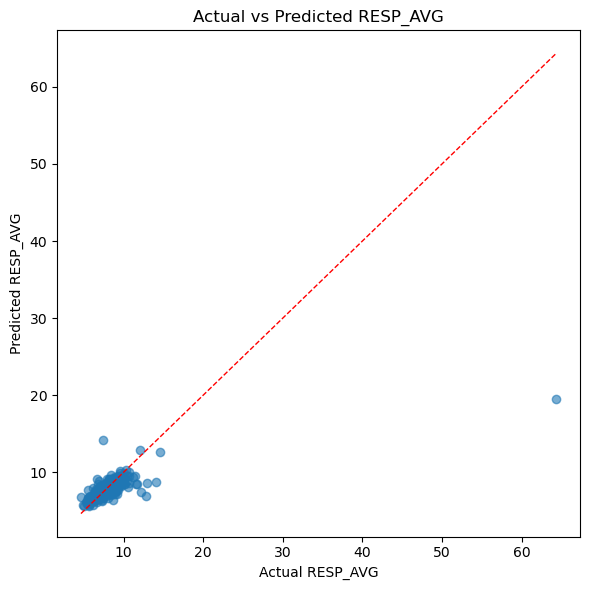

In [35]:
#actual vs predicted plot
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', linewidth=1)
plt.xlabel('Actual RESP_AVG')
plt.ylabel('Predicted RESP_AVG')
plt.title('Actual vs Predicted RESP_AVG')
plt.tight_layout()
plt.show()

A top view of the graph:
Most of the points are centered around the 5-12 second values, and are relatively close to the red line, which indicates that the model predicts reasonably well in the normal ranges. On the other hand, there are a number of extreme points where the model predicts poorly, meaning it does not respond well to these peaks.

### The expected average response time under average load is multiplied by 2.

In [36]:
X_test_doubled = X_test.copy()
X_test_doubled['log_VOLUME'] = np.log1p(2*(np.expm1(X_test['log_VOLUME'])))


X_test_doubled[['hour', 'weekday', 'rm_resp', 'rs_resp']] = X_test[['hour', 'weekday', 'rm_resp', 'rs_resp']]


In [37]:
#scale the new test set
X_test_doubled_scaled = scaler.transform(X_test_doubled)

#predict the new test set
y_pred_doubled = model.predict(X_test_doubled_scaled)


In [38]:
#evaluate the new predictions
mean_current = y_test.mean()
mean_doubled = y_pred_doubled.mean()
pct_change = ((mean_doubled - mean_current) / mean_current) * 100

print(f"Average RESP_AVG (current): {mean_current:.3f} s")
print(f"Average RESP_AVG (2× load): {mean_doubled:.3f} s")
print(f"% change: {pct_change:.1f}%")

Average RESP_AVG (current): 8.010 s
Average RESP_AVG (2× load): 7.874 s
% change: -1.7%


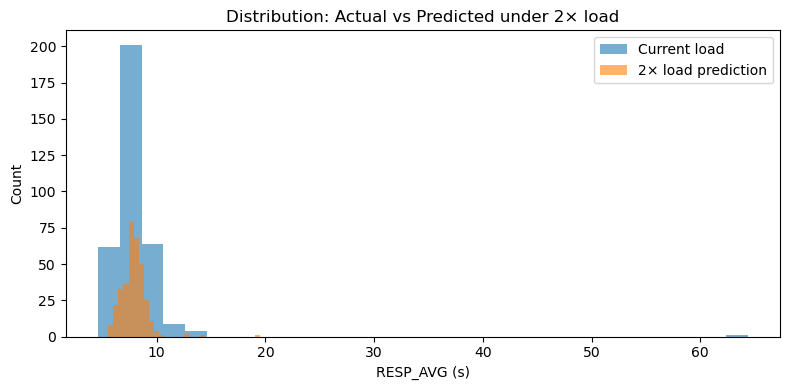

In [39]:
#histogram of the predicted values
plt.figure(figsize=(8,4))
plt.hist(y_test,bins=30, alpha=0.6, label='Current load')
plt.hist(y_pred_doubled,bins=30, alpha=0.6, label='2× load prediction')
plt.xlabel('RESP_AVG (s)')
plt.ylabel('Count')
plt.legend()
plt.title('Distribution: Actual vs Predicted under 2× load')
plt.tight_layout()
plt.show()

### What do we understand from the histogram about the difference between doubling the quantity and the current situation:
- A slight deviation in the average response time, although it seems that in the real case the average response time was smaller, it can be seen that in the orange histogram the average and most of the values ​​are slightly tilted to the right, meaning an increase in response time.

- The spread of the values ​​is narrowing - the spread of the orange histogram is slightly narrower compared to the blue, which indicates that the model predicts a “fixed effect” of doubling the load, and does not derive much from the same effect at all time points.

## Summary section 2
**Model selection and explanation** 

I chose to use the linear Regression model on the log_volume features and the features I created. All this in order to summarize the relationship between load and response time, to prevent overfitting due to the few observations I have in the data.

### What steps did I take in analyzing and training the model and its prediction-
- Initial EDA: scatter and checking correlations between the columns
- feather engineering: I chose to add and enrich my data in preparation for building the model I will take. Normalizing the volume column by log, ratio of the resp_avg column to it, adding mean std to the average response time
- Division into a training and test set according to 80/20
- Lowering the values ​​(normalization) by StandardScaler, all this in order to prepare the values ​​for proper training for linear regression models.
- Training and evaluation on the train.
- Finding r^2 and rmse measures
- Histogram analysis of the current and predicted situation.
- Adding the amount of requests based on double the demand of what were the real values.
- Changes in the test values ​​with the new multiplication, and a new prediction with the new values.
- Comparing distributions between load double 2 versus the normal case presented